## Исследование влияния learning rate на качество прогнозирования моделей RNN и LSTM

### Подключение библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam

import sys
import os
sys.path.append(os.path.abspath('..'))
from helpful_functions import train_val_test_split, \
                              create_sequences,\
                              denormalize, \
                              train_and_evaluate_model

## 1. Загрузка данных

In [2]:
file_path = '../dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

target_feature = 'Global_active_power'
test_ratio = 0.10
val_ratio = 0.10

train_data, val_data, test_data = train_val_test_split(df, val_ratio, test_ratio)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_idx = df.columns.get_loc(target_feature)

features_count = train_data.shape[1]

## 2. Обучение моделей

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
window_sizes = [10, 30, 60, 90, 120]
results = []

for window_size in window_sizes:
    X_train, y_train = create_sequences(train_scaled, target_idx, window_size)
    X_val, y_val = create_sequences(val_scaled, target_idx, window_size)
    X_test, y_test = create_sequences(test_scaled, target_idx, window_size)

    for lr in learning_rates:
        print(f"\nTraining RNN | learning_rate = {lr} | window_size = {window_size}")
        
        rnn_model = Sequential([
            Input(shape=(window_size, features_count)),
            SimpleRNN(50, activation='tanh'),
            Dense(1)
        ])
        result_rnn = train_and_evaluate_model(
            rnn_model, 'RNN', X_train, y_train, X_val, y_val, X_test, y_test,
            lr, window_size, scaler, target_feature, df.columns
        )
        results.append(result_rnn)

        print(f"\nTraining LSTM | learning_rate = {lr} | window_size = {window_size}")
        
        lstm_model = Sequential([
            Input(shape=(window_size, features_count)),
            LSTM(50, activation='tanh'),
            Dense(1)
        ])
        result_lstm = train_and_evaluate_model(
            lstm_model, 'LSTM', X_train, y_train, X_val, y_val, X_test, y_test,
            lr, window_size, scaler, target_feature, df.columns
        )
        results.append(result_lstm)


Training RNN | learning_rate = 0.1 | window_size = 10
RNN | val_loss: 0.0652 | MSE: 7.9584

Training LSTM | learning_rate = 0.1 | window_size = 10
LSTM | val_loss: 0.0004 | MSE: 0.0533

Training RNN | learning_rate = 0.01 | window_size = 10
RNN | val_loss: 0.0004 | MSE: 0.0545

Training LSTM | learning_rate = 0.01 | window_size = 10
LSTM | val_loss: 0.0004 | MSE: 0.0431

Training RNN | learning_rate = 0.001 | window_size = 10
RNN | val_loss: 0.0004 | MSE: 0.0462

Training LSTM | learning_rate = 0.001 | window_size = 10
LSTM | val_loss: 0.0004 | MSE: 0.0438

Training RNN | learning_rate = 0.0001 | window_size = 10
RNN | val_loss: 0.0004 | MSE: 0.0471

Training LSTM | learning_rate = 0.0001 | window_size = 10
LSTM | val_loss: 0.0004 | MSE: 0.0466

Training RNN | learning_rate = 0.1 | window_size = 30
RNN | val_loss: 0.0386 | MSE: 4.7124

Training LSTM | learning_rate = 0.1 | window_size = 30
LSTM | val_loss: 0.0056 | MSE: 0.6866

Training RNN | learning_rate = 0.01 | window_size = 30
RN

## 3. Сравнение результатов

In [4]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by=['mse_val_dn']))

   model_type  learning_rate  window_size  train_loss  val_loss  mse_val_dn  \
11       LSTM         0.0100           30    0.000457  0.000346    0.042267   
19       LSTM         0.0100           60    0.000465  0.000348    0.042412   
13       LSTM         0.0010           30    0.000494  0.000350    0.042759   
3        LSTM         0.0100           10    0.000463  0.000353    0.043082   
37       LSTM         0.0010          120    0.000486  0.000357    0.043519   
29       LSTM         0.0010           90    0.000488  0.000357    0.043611   
27       LSTM         0.0100           90    0.000465  0.000358    0.043706   
21       LSTM         0.0010           60    0.000489  0.000359    0.043807   
5        LSTM         0.0010           10    0.000498  0.000359    0.043845   
35       LSTM         0.0100          120    0.000465  0.000363    0.044297   
39       LSTM         0.0001          120    0.000538  0.000379    0.046186   
4         RNN         0.0010           10    0.00052

## 4. Нахождение лучших результатов для каждой модели

In [5]:
results_df = pd.DataFrame(results)

best_rnn = results_df[results_df['model_type'] == 'RNN'].nsmallest(1, 'mse_val_dn').iloc[0]
best_lstm = results_df[results_df['model_type'] == 'LSTM'].nsmallest(1, 'mse_val_dn').iloc[0]

print("\nЛучшая RNN (по валидации):")
print(best_rnn[['model_type', 'learning_rate', 'window_size', 'mse_val_dn', 'mse_test_dn']])
print("\nЛучшая LSTM (по валидации):")
print(best_lstm[['model_type', 'learning_rate', 'window_size', 'mse_val_dn', 'mse_test_dn']])


Лучшая RNN (по валидации):
model_type            RNN
learning_rate       0.001
window_size            10
mse_val_dn        0.04622
mse_test_dn      0.039411
Name: 4, dtype: object

Лучшая LSTM (по валидации):
model_type           LSTM
learning_rate        0.01
window_size            30
mse_val_dn       0.042267
mse_test_dn      0.035278
Name: 11, dtype: object


## 5. Заново получаем предсказания этих моделей

In [6]:
X_train_rnn, y_train_rnn = create_sequences(train_scaled, target_idx, best_rnn['window_size'])
X_val_rnn, y_val_rnn = create_sequences(val_scaled, target_idx, best_rnn['window_size'])

X_train_lstm, y_train_lstm = create_sequences(train_scaled, target_idx, best_lstm['window_size'])
X_val_lstm, y_val_lstm = create_sequences(val_scaled, target_idx, best_lstm['window_size'])

rnn_model = Sequential([
    Input(shape=(best_rnn['window_size'], features_count)),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(learning_rate=best_rnn['learning_rate']), loss='mse')
rnn_model.fit(X_train_rnn, y_train_rnn, epochs=5, batch_size=256, validation_data=(X_val_rnn, y_val_rnn), verbose=0)

lstm_model = Sequential([
    Input(shape=(best_lstm['window_size'], features_count)),
    LSTM(50, activation='tanh'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=best_lstm['learning_rate']), loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=256, validation_data=(X_val_lstm, y_val_lstm), verbose=0)

### Сохраняем модели

In [7]:
# from tensorflow.keras.models import load_model
# rnn_model = load_model('../models/best_rnn_model.keras')
# lstm_model = load_model('../models/best_lstm_model.keras')

rnn_model.save('../models/best_rnn_model.keras')
lstm_model.save('../models/best_lstm_model.keras')

## 6. Делаем предсказания

In [8]:
y_pred_rnn = rnn_model.predict(X_val_rnn, verbose=0)
y_pred_rnn_dn = denormalize(scaler, y_pred_rnn, target_feature, df.columns)
y_true_val_dn = denormalize(scaler, y_val_rnn.reshape(-1, 1), target_feature, df.columns)

y_pred_lstm = lstm_model.predict(X_val_lstm, verbose=0)
y_pred_lstm_dn = denormalize(scaler, y_pred_lstm, target_feature, df.columns)

## 7. Построение графиков моделей на одном window size 

6485/6485 ━━━━━━━━━━━━━━━━━━━━ 5s 819us/step
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


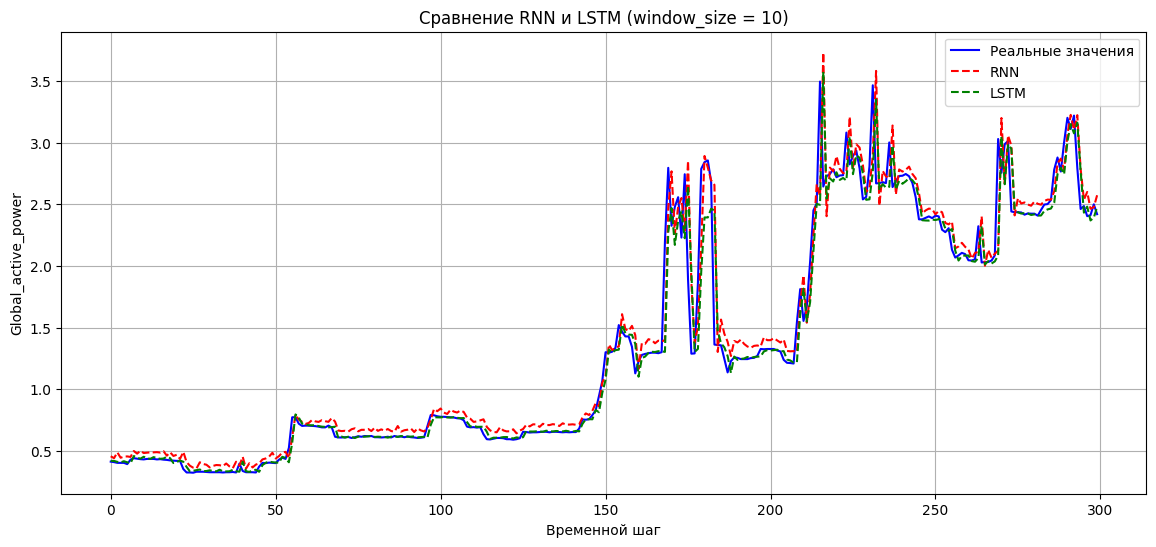

In [9]:
common_window_size = min(best_rnn['window_size'], best_lstm['window_size'])

X_val_common, y_val_common = create_sequences(val_scaled, target_idx, common_window_size)

y_pred_rnn_common = rnn_model.predict(X_val_common)
y_pred_lstm_common = lstm_model.predict(X_val_common)

y_pred_rnn_dn = denormalize(scaler, y_pred_rnn_common, target_feature, df.columns)
y_pred_lstm_dn = denormalize(scaler, y_pred_lstm_common, target_feature, df.columns)
y_true_val_dn = denormalize(scaler, y_val_common.reshape(-1, 1), target_feature, df.columns)

plt.figure(figsize=(14, 6))
plt.plot(y_true_val_dn[:300], label='Реальные значения', color='blue')
plt.plot(y_pred_rnn_dn[:300], label='RNN', color='red', linestyle='--')
plt.plot(y_pred_lstm_dn[:300], label='LSTM', color='green', linestyle='--')

plt.title(f"Сравнение RNN и LSTM (window_size = {common_window_size})")
plt.xlabel("Временной шаг")
plt.ylabel("Global_active_power")
plt.legend()
plt.grid(True)
plt.show()